In [1]:
import os
import nibabel as nib
import numpy as np
from nibabel.testing import data_path
import pyopenvdb as vdb
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

from functions import parent_directory, normalize_array, view_sagittal_slices, create_volume, plot_examples, iso_scale_trans
import copy

In [2]:
#Set up output folders
parent_directory = parent_directory()

In [3]:
anat_filepath = "/workspaces/neurovolume/media/sub-01/anat/sub-01_T2w.nii.gz"
anat_image = nib.load(anat_filepath)

anat_norm = create_volume(normalize_array(anat_image.get_fdata()))

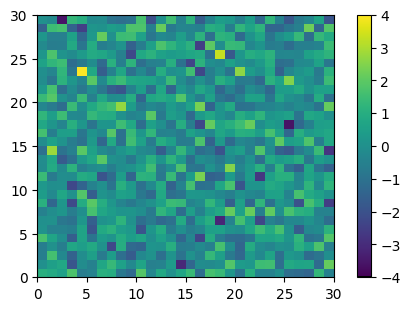

In [4]:
norm_viridis = mpl.colormaps['viridis'].resampled(256) # TODO check if your anat_norm is 8-bit float?
newcolors = norm_viridis(np.linspace(0,1,256))
black = np.array([0,0,0,1])
newcolors[:1,:] = black
black_zero = ListedColormap(newcolors)

plot_examples([black_zero])

mpl.colormaps.register(cmap=black_zero)

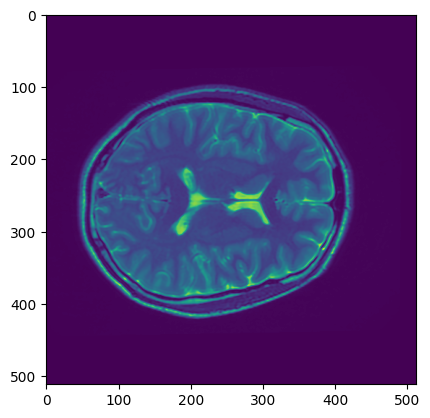

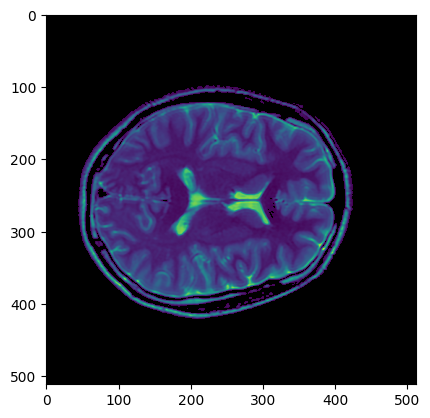

In [5]:
clipped_anat_norm = copy.deepcopy(anat_norm)
np.clip(clipped_anat_norm, 0.1, 1.0, clipped_anat_norm)

mid = int(clipped_anat_norm.shape[2]/2)

plt.imshow(anat_norm[:,:,mid])
plt.show()
plt.set_cmap(black_zero)
plt.imshow(clipped_anat_norm[:,:,mid])
plt.show()


# You can also do this in openvdb:
# grid.copyFromArray(array, tolerance=0.2)
# however, this allows you to do a quick visual check of your threshold


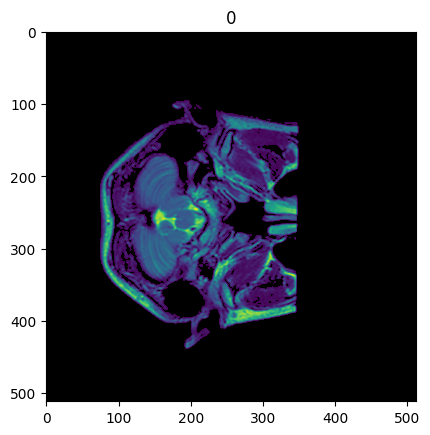

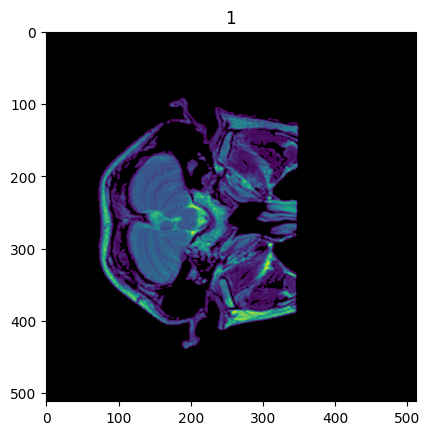

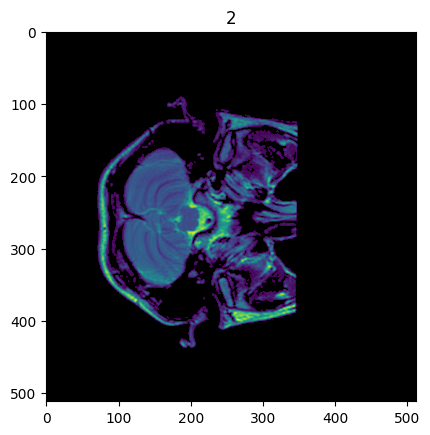

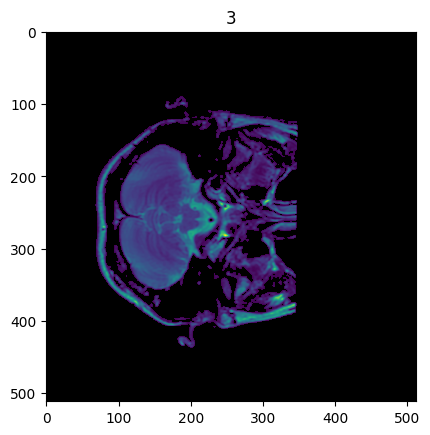

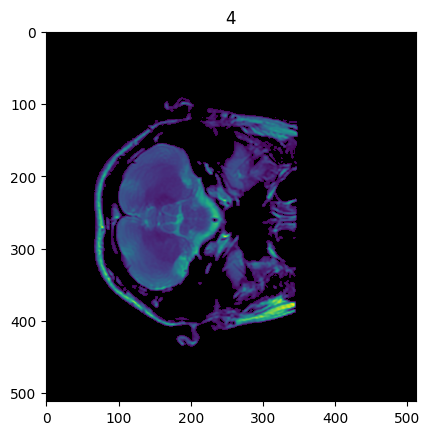

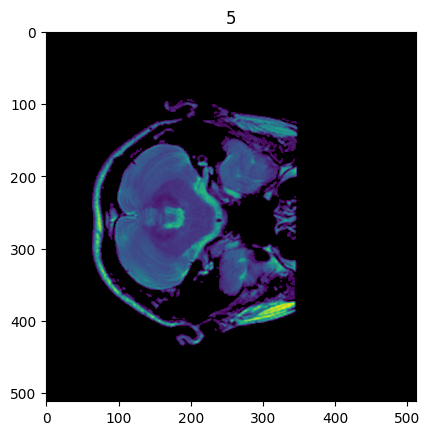

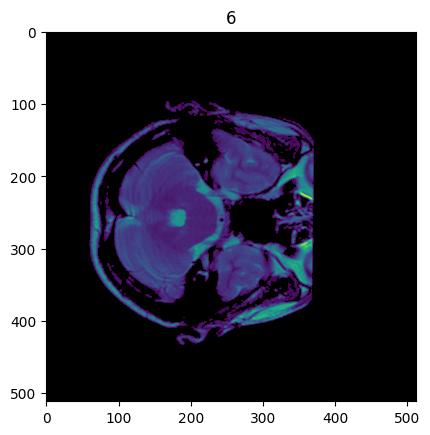

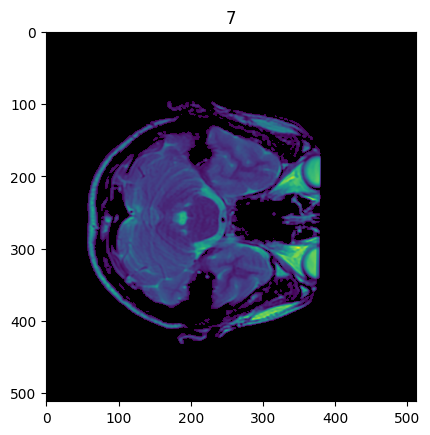

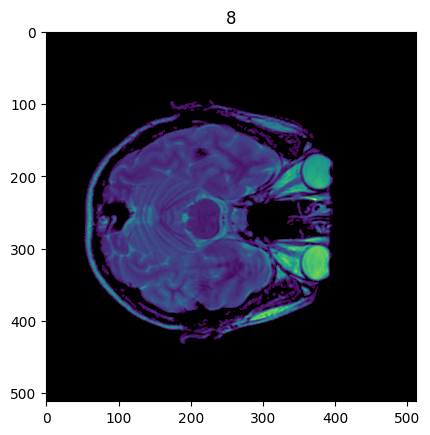

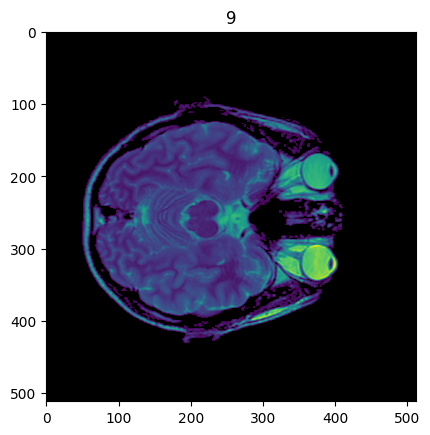

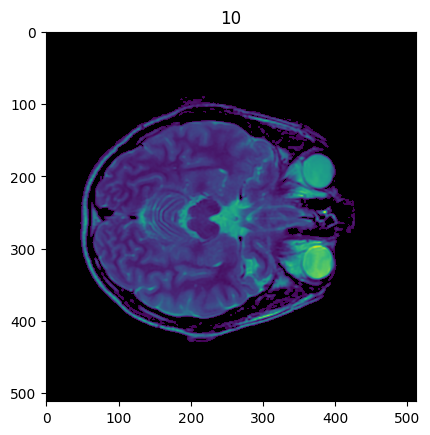

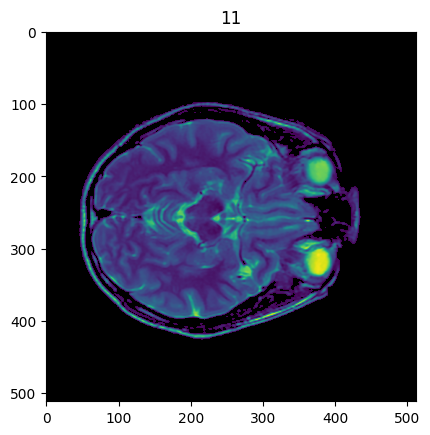

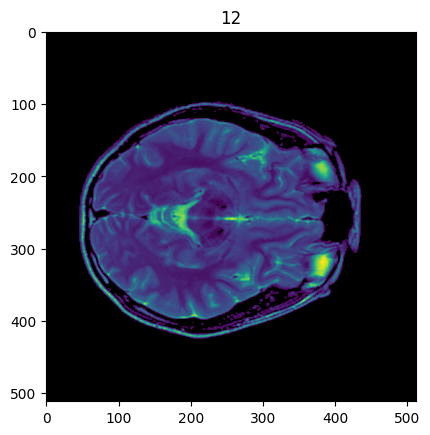

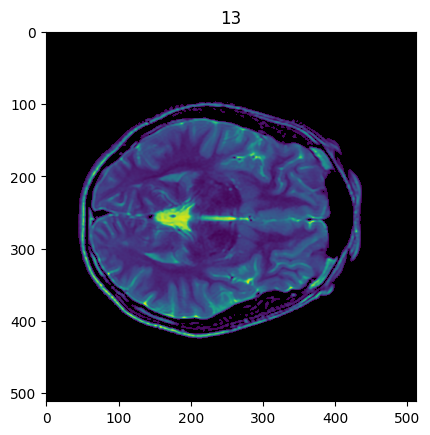

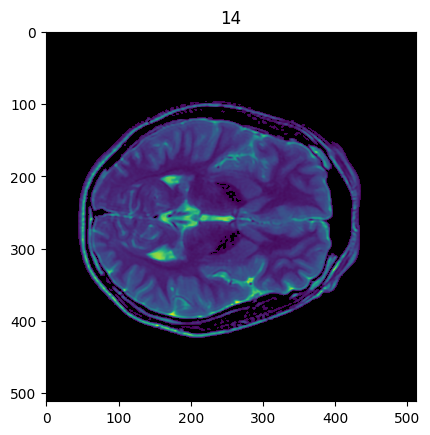

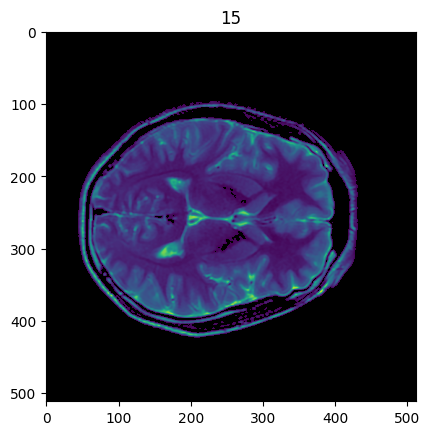

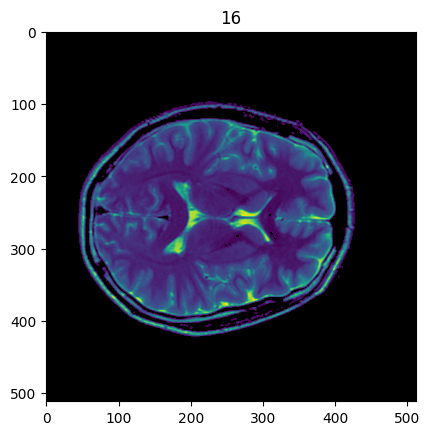

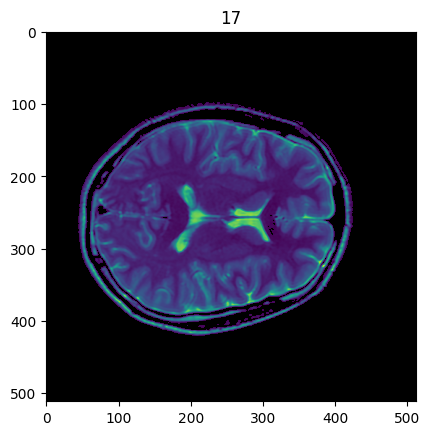

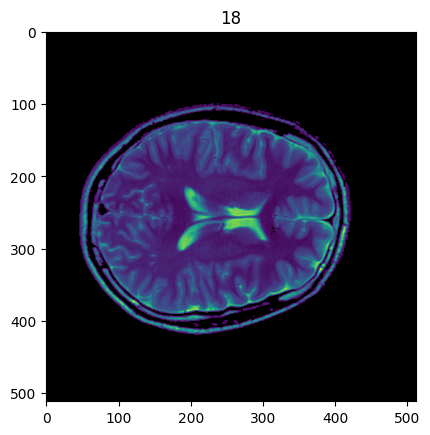

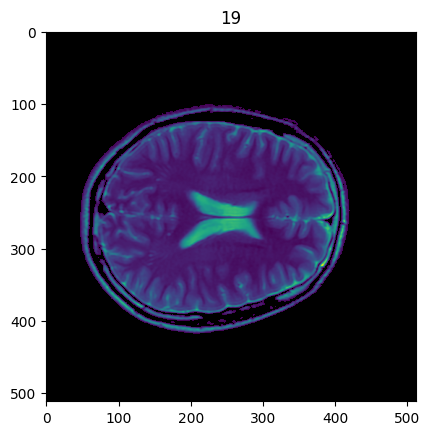

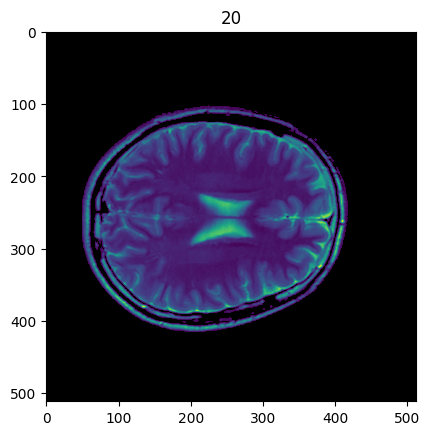

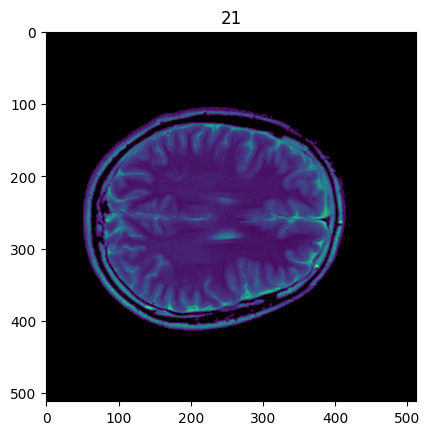

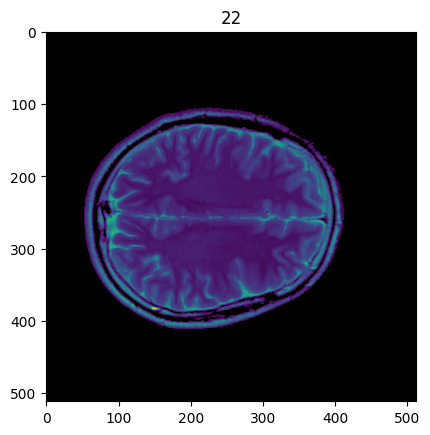

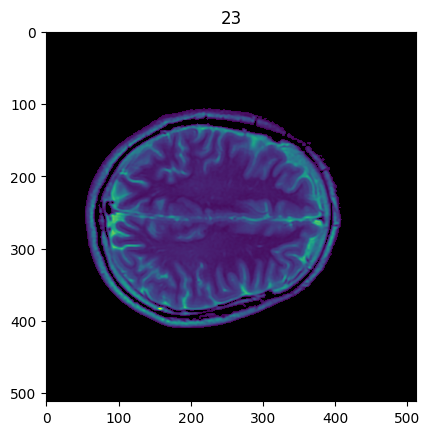

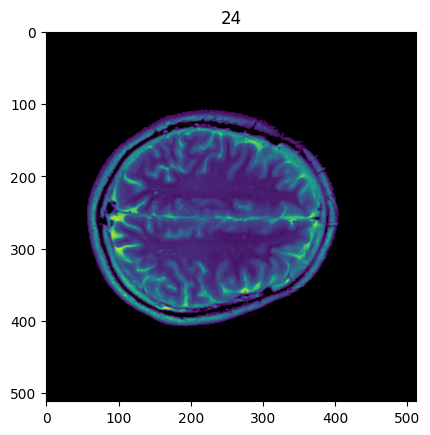

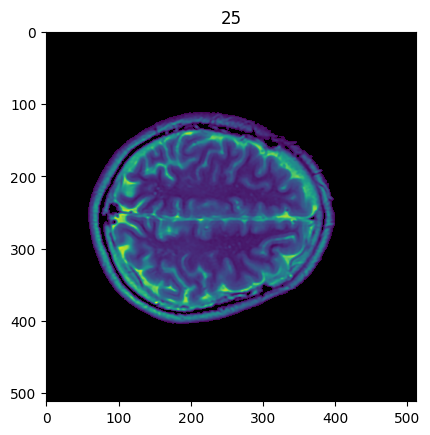

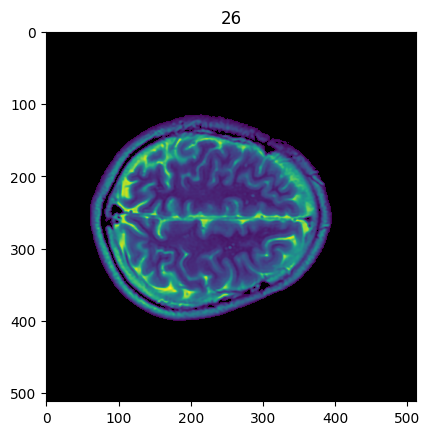

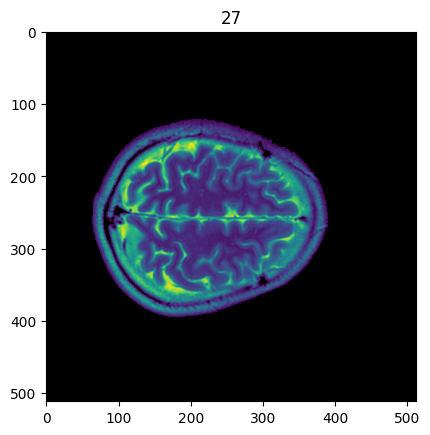

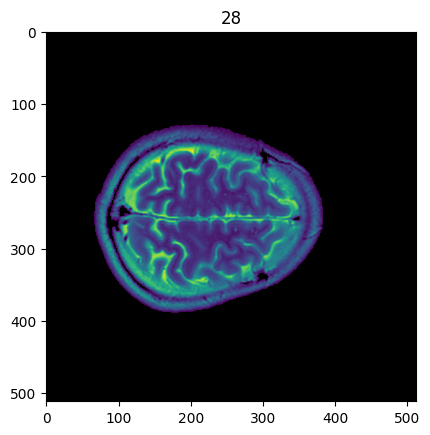

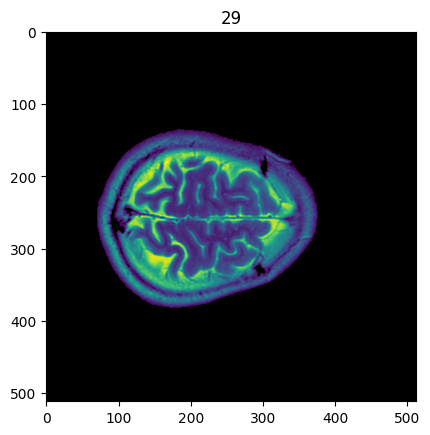

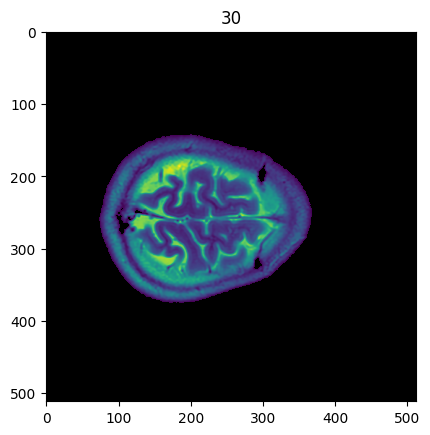

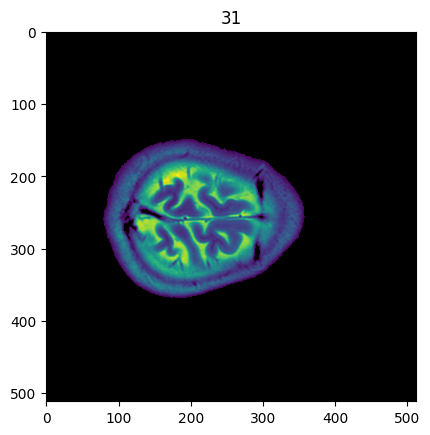

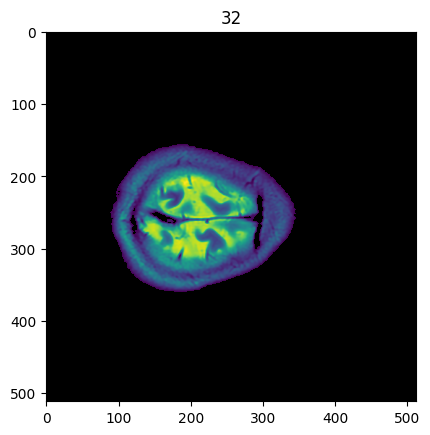

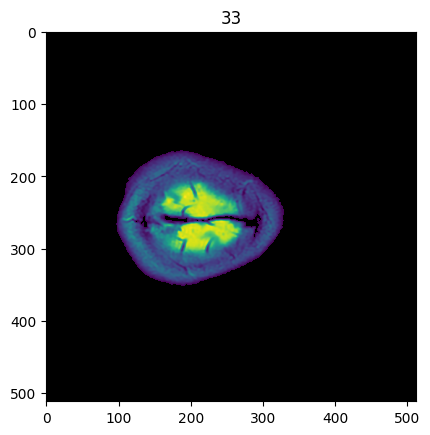

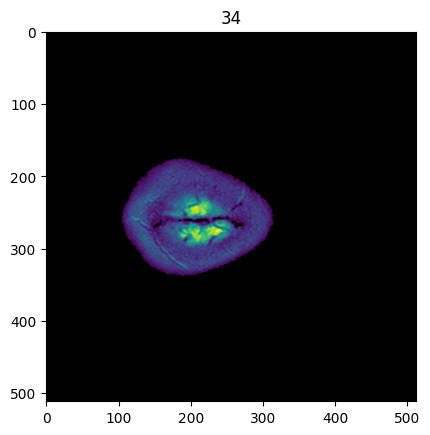

In [6]:
view_sagittal_slices(clipped_anat_norm, black_zero)

In [7]:
#create scale/rotation affine only
# It seems like `createLinearTranform` just wants the -45 degree slices
# that is to say, it just does scaling and transformation
hardcoded_tf_modifid = [
    [-0.5, 0.0, 0.0, 0.0],
    [0.0, 0.5, 0.0, 0.0],
    [0.0, 0.0, 4.0, 0.0],
    [0.0, 0.0, 0.0, 1.0],
]
# TODO write code to do this later
# it is from:
print(anat_image.affine)

[[  -0.5           0.           -0.          129.70300293]
 [  -0.            0.5          -0.         -110.68299866]
 [   0.            0.            4.          -74.83930206]
 [   0.            0.            0.            1.        ]]


In [8]:
print(iso_scale_trans(anat_image.affine))

[[-0.5, 0.0, 0.0, 0.0], [0.0, 0.5, 0.0, 0.0], [0.0, 0.0, 4.0, 0.0], [0.0, 0.0, 0.0, 1.0]]


In [10]:
grid = vdb.FloatGrid() #DoubleGrid no longer avail?
grid.copyFromArray(anat_norm.astype(float))
grid.transform = vdb.createLinearTransform(iso_scale_trans(anat_image.affine)) # accepts only scale and translate (all else must be zeros)
grid.gridClass = vdb.GridClass.FOG_VOLUME
grid.name='density'

In [11]:
output_path = os.path.join(parent_directory, "output/", "sub01_anat.vdb")

In [12]:
vdb.write(output_path, grid)

# Docker copy commands
`docker cp 4ba02c34fa159f23009802e83ead97b06e98831bd1b14e2dc843c901b367694e:/workspaces/neurovolume/output/sub01_anat.vdb ./sub01_anat.vdb`